
Optimized Parameters:
mu = 0.01000, alpha =  1.50000, beta = 0.34386, gamma = 0.50000, c1 = 0.21000, c2 = 0.21000, c3 = 2.00000, K = 0.21000

Validation Metrics:
RMSE for LO: 0.1814
RMSE for LL: 0.3017
R² for LO: 0.7588
R² for LL: 0.1201
Pearson r (N): 0.878 (p=0.009)
Pearson r (P): 0.462 (p=0.297)

DTW distance (N): 1.001
DTW distance (P): 1.487


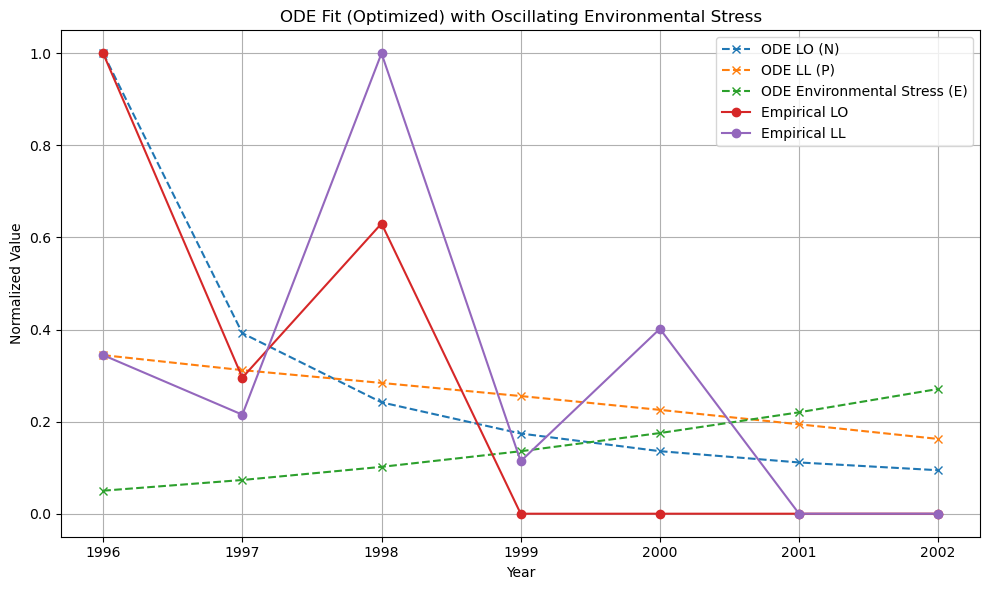

In [105]:
#  SETUP to replicate Appendix F, figure. 25
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Species Options:
# LL LO NL TT FV AN ME MM

# Toggle: Use Optimizer or Manual Parameter Fitting
use_optimizer = True

#  LOAD ECOLOGICAL ENTROPY DATA: insert local file address 
entropy_df = pd.read_csv("/Users/a.m.rodriguez/Desktop/COMPLEX SYSTEMS/ECOLOGY_complex_systems/ecology_datasets_2025/July_2025_ecology_data/Maine_intertidal_data/Species_Entropy_Trajectories.csv", index_col="Year")

# Select two species (traits) for analysis:
trait_x = "LO"  # e.g., Fucus vesiculosus
trait_y = "LL"  # e.g., Littorina littorea

# Prepare time and normalized trait vectors
# Align years and drop rows with missing data in either trait
aligned = entropy_df[[trait_x, trait_y]].dropna()
common_years = aligned.index.values
t_data = common_years - common_years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min()) if arr.max() > arr.min() else np.zeros_like(arr)

N_empirical = normalize(aligned[trait_x].values)
P_empirical = normalize(aligned[trait_y].values)

#  ECTO SYSTEM 
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.08
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

init_conditions = [N_empirical[0], P_empirical[0], 0.05]

def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

#  PARAMETERS 
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.08, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.00001, 1.5), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # Manual parameter tuning
    mu    = 0.00001
    alpha = 0.15
    beta  = 0.16746
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 15.60
    K     = 0.5

#  READY TO RUN 
# Simulation, validation, and plotting code can now follow as in your original script
# Just reuse the rest of your original cells to finish the run
#  SIMULATE SYSTEM 
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# === VALIDATION ===
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]


rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

#  OUTPUT 
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

#  PLOT 
plt.figure(figsize=(10, 6))
plt.plot(common_years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(common_years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(common_years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(common_years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(common_years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Oscillating Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Optimized Parameters:
mu = 0.01000, alpha =  0.12153, beta = 0.29664, gamma = 0.50000, c1 = 0.21000, c2 = 0.21000, c3 = 2.00000, K = 0.21000

Validation Metrics:
RMSE for TT: 0.2836
RMSE for LL: 0.2984
R² for TT: 0.0985
R² for LL: 0.1389
Pearson r (N): 0.570 (p=0.182)
Pearson r (P): 0.490 (p=0.265)

DTW distance (N): 1.416
DTW distance (P): 1.476


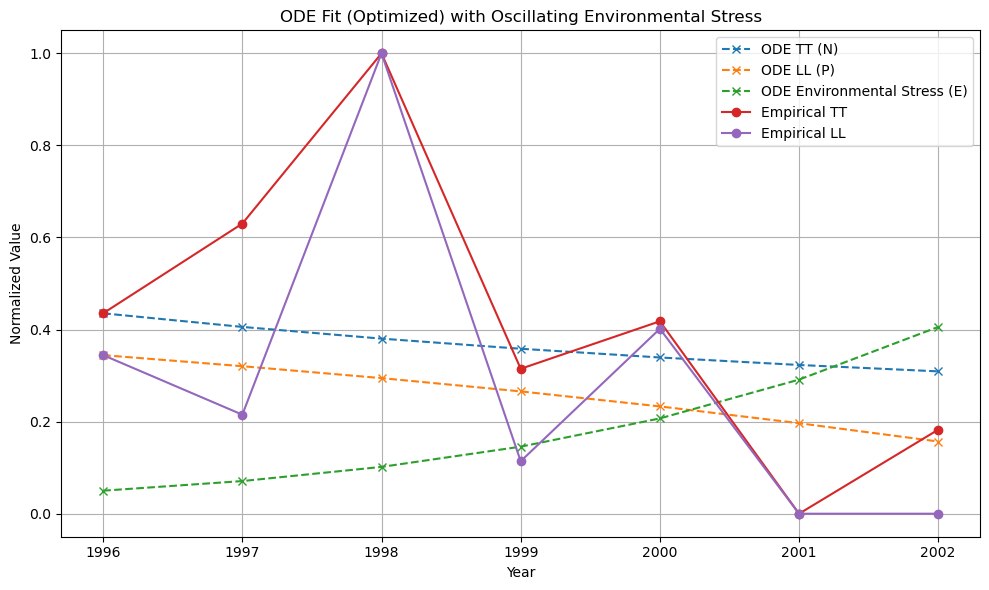

In [86]:
#  SETUP to Replicate Appendix F, figure. 26
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Species Options:
# LL LO NL TT FV AN ME MM

# Toggle: Use Optimizer or Manual Parameter Fitting
use_optimizer = True

#  LOAD ECOLOGICAL ENTROPY DATA insert local file address
entropy_df = pd.read_csv("/Users/a.m.rodriguez/Desktop/COMPLEX SYSTEMS/ECOLOGY_complex_systems/ecology_datasets_2025/July_2025_ecology_data/Maine_intertidal_data/Species_Entropy_Trajectories.csv", index_col="Year")

# Select two species (traits) for analysis:
trait_x = "TT"  # e.g., Fucus vesiculosus
trait_y = "LL"  # e.g., Littorina littorea

# Prepare time and normalized trait vectors
# Align years and drop rows with missing data in either trait
aligned = entropy_df[[trait_x, trait_y]].dropna()
common_years = aligned.index.values
t_data = common_years - common_years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min()) if arr.max() > arr.min() else np.zeros_like(arr)

N_empirical = normalize(aligned[trait_x].values)
P_empirical = normalize(aligned[trait_y].values)

#  ECTO SYSTEM 
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.08
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

init_conditions = [N_empirical[0], P_empirical[0], 0.05]

def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

#  PARAMETERS 
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.08, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.00001, 1.5), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # Manual parameter tuning
    mu    = 0.00001
    alpha = 0.15
    beta  = 0.16746
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 15.60
    K     = 0.5

#  READY TO RUN 
# Simulation, validation, and plotting code can now follow as in your original script
# Just reuse the rest of your original cells to finish the run
#  SIMULATE SYSTEM 
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

#  VALIDATION 
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]


rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === OUTPUT ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === PLOT ===
plt.figure(figsize=(10, 6))
plt.plot(common_years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(common_years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(common_years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(common_years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(common_years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Oscillating Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
